# Reverse Cellular Automaton: Rule-Based and Machine Learning Approach
This project implements a Reverse Cellular Automaton using a combination of rule-based modeling and machine learning. The key steps include:

### 1. Initialize a Random 1D Grid:

A 1D binary grid is generated and displayed using Seaborn heatmap for consistency.

### 2. Apply Rule-Based Evolution:

A predefined set of transition rules is applied iteratively to evolve the grid over multiple steps.

### 4. Extract Training Data:

Training samples are extracted based on a 5-cell neighborhood, forming input-output pairs.

### 5. Train a Random Forest Classifier:

A Random Forest model is trained to learn the transition rules from the generated data.

### 6. Apply the Learned Model:

The trained model is used to predict future states of the automaton.

### 7. Visualize Results:

- The original rule-generated and the machine-learned grids are displayed.

- A confusion matrix and classification report evaluate the model's accuracy.


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from collections import Counter

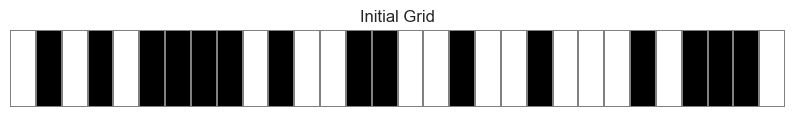

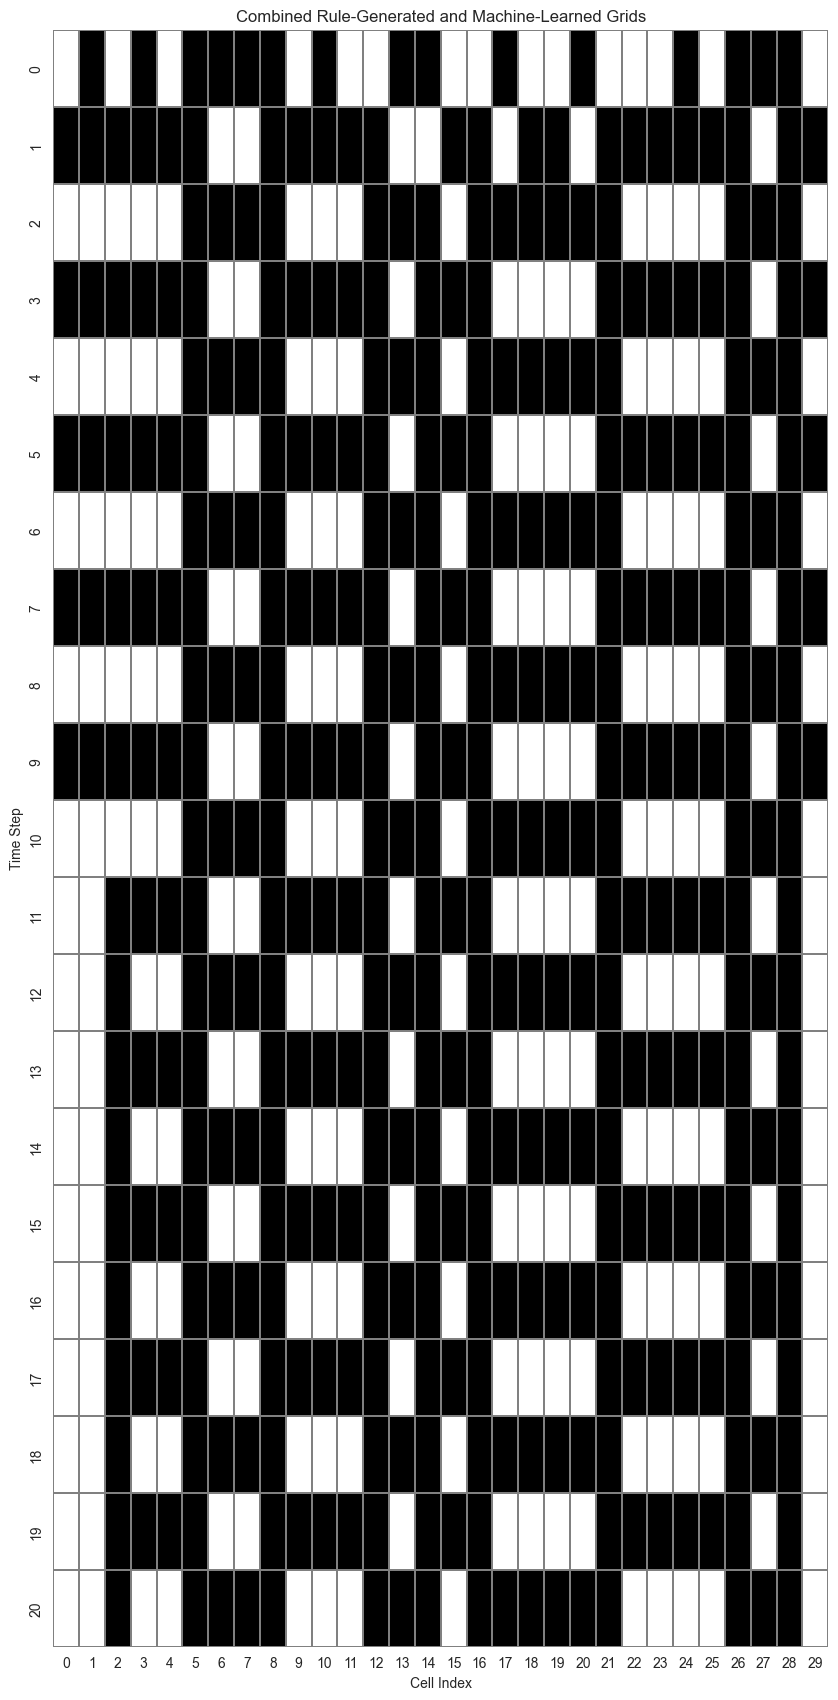

Test Accuracy on Combined Grids: 0.9712

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.96        35
           1       0.96      1.00      0.98        69

    accuracy                           0.97       104
   macro avg       0.98      0.96      0.97       104
weighted avg       0.97      0.97      0.97       104


Confusion Matrix:


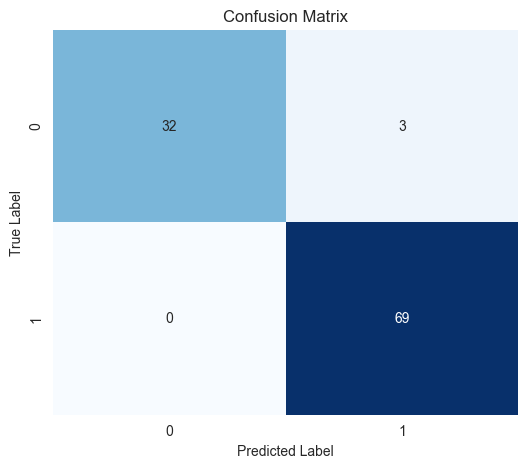

In [11]:

"""Design a 1D grid of 0s and 1s and display it."""
def initialize_grid_custom(size):
    # Initialize a grid with random initial states of 0s (black-dead) and 1s (white-alive)
    grid = np.random.choice([0, 1], size=size)  
    
    # Display the grid using seaborn heatmap for consistency
    plt.figure(figsize=(10, 1))
    sns.heatmap(grid.reshape(1, -1), cmap='binary', cbar=False, linewidths=0.2, linecolor='gray')
    plt.xticks(range(len(grid)))
    plt.yticks([])  # Hide y-ticks
    plt.title("Initial Grid")
    plt.show()
    
    return grid



""" Define and apply underlying rules for multiple steps and return the generated grids."""
def apply_rule(grid, steps=10):
    grids = [grid.copy()]   # create a copy of the initial grid
    
    for _ in range(steps):
        new_grid = grids[-1].copy()
        for i in range(len(grid)):
            # Define the neighborhood considering periodic boundary conditions
            left2 = grids[-1][(i - 2) % len(grid)]  # Wraps around to the last cell if i-2 < 0
            left1 = grids[-1][(i - 1) % len(grid)]  # Wraps around to the last cell if i-1 < 0
            center = grids[-1][i]
            right1 = grids[-1][(i + 1) % len(grid)]  # Wraps around to the first cell if i+1 >= len(grid)
            right2 = grids[-1][(i + 2) % len(grid)]  # Wraps around to the first cell if i+2 >= len(grid)

            # Create the transition rules
            if center == 0 and (left1 == 1 or right1 == 1):
                new_grid[i] = 1  # 0 → 1 if at least one immediate neighbor is 1
            elif center == 1 and (left2 == right2 == 0):
                new_grid[i] = 0  # 1 → 0 if distant neighbors are 0
            elif left1 == 0 and right1 == 0:  # Encourage change when neighbors are both 0
                new_grid[i] = 1
            elif left1 == 1 and right1 == 1:  # Encourage change when both neighbors are 1
                new_grid[i] = 0
            
        grids.append(new_grid)
    
    return grids



# Display generated grids
def display_generated_grids(grids, title="Generated Grids"):
    """Enhanced visualization of generated grids."""
    plt.figure(figsize=(10, len(grids)))
    sns.heatmap(np.array(grids), cmap='binary', cbar=False, linewidths=0.2, linecolor='gray')
    plt.xlabel("Cell Index")
    plt.ylabel("Time Step")
    plt.title(title)
    plt.show()



"""Extracts training data (neighborhood -> next state) 
pairs from grid sequences."""
def extract_training_data(grids):
    X, y = [], []
    for t in range(len(grids) - 1):
        grid, next_grid = grids[t], grids[t + 1]
        for i in range(2, len(grid) - 2):
            neighborhood = grid[i - 2:i + 3]  # 5-cell neighborhood
            X.append(neighborhood)
            y.append(next_grid[i])
    
    return np.array(X), np.array(y)


# Train Random Forest model
def train_random_forest(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
    model.fit(X_train, y_train)
    return model


# Apply learned rule from the last generated grid and generate more grids
def apply_learned_rule_from_last(last_grid, model, iterations=10):
    """Generate new grids based on the learned model from the last grid."""
    new_grids = [last_grid]
    current_state = last_grid
    
    for _ in range(iterations):
        new_state = current_state.copy()
        for i in range(2, len(current_state) - 2):
            neighborhood = current_state[i - 2:i + 3].reshape(1, -1)  # Use 5-cell neighborhood
            new_state[i] = model.predict(neighborhood)[0]
        new_grids.append(new_state)
        current_state = new_state
    
    return new_grids


# Main Execution
initial_state = initialize_grid_custom(size=30)  # Define grid size of initial state
generated_grids = apply_rule(initial_state, steps=10)  # Generate grids using rule-based model

# Generate machine-learned grids from the original rule-generated grids
X, y = extract_training_data(generated_grids)

# Split data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the random forest classifier on the rule-based data
model = train_random_forest(X_train, y_train)


# Apply the learned model to continue grid generation from the last generated grid
predicted_grids = apply_learned_rule_from_last(generated_grids[-1], model, iterations=10)

# Combine original grids with the machine-learned generated grids
combined_grids = generated_grids + predicted_grids[1:]  # Skip the duplicate first step

# Display the combined rule-generated and machine-learned generated grids
display_generated_grids(combined_grids, title="Combined Rule-Generated and Machine-Learned Grids")

# Now, train the model on the combined grids
X_combined, y_combined = extract_training_data(combined_grids)

# Split data into training and testing sets (for the combined grids)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

# Train the random forest classifier on the combined grids
model_combined = train_random_forest(X_train_combined, y_train_combined)

# Evaluate the model on the combined grids
y_pred_combined = model_combined.predict(X_test_combined)

# Display accuracy
test_accuracy_combined = accuracy_score(y_test_combined, y_pred_combined)
print(f"Test Accuracy on Combined Grids: {test_accuracy_combined:.4f}")

# Print classification report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test_combined, y_pred_combined))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_combined, y_pred_combined)
print("\nConfusion Matrix:")
# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


